# 11. GAN

생성적 적대 신경망은 아이디어 자체로만으로 매우 가치있는 모델로 평가 받고 있다. 실제 얼굴 변환, 생성, 음성 변조, 그림 스타일 변환, 사진 복원 등 다양한 기술로 응용이 되어 실제 적용되고 있다.

바닐라 GAN : 일반적인 형태의 GAN

## 11.1 라이브러리 및 데이터 불러오기

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.variable import Variable
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import imageio

import numpy as np
from matplotlib import pyplot as plt

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,),(0.5,))
                ])
to_image = transforms.ToPILImage()
trainset = FashionMNIST(root='./data/', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 'T-Shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## 11.2 모델 정의

In [3]:
#GAN 모델 자체가 훈련이 어려운 경우가 많다.
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128 #Latent 벡터 혹은 Latent feature는 원하는대로 정해주면 된다. 즉, 어느정도 랜덤으로 시작가능
        self.n_out = 784 #패션 mnist 데이터는 28 * 28 이미지다.
        self.linear = nn.Sequential(
                    nn.Linear(self.n_features, 256),  #만약 이부분들을 CNN으로 바꾸면 DC GAN이다.
                    nn.LeakyReLU(0.2), #다잉 Relu 현상을 방지하기 위해 LeakyRelu 사용, Relu는 음수값을 0으로 만들기 때문에 다시 미분을 했을때 0으로 수렴한다.
                    nn.Linear(256, 512),
                    nn.LeakyReLU(0.2), #0.2는 기울기를 의미한다.
                    nn.Linear(512, 1024),
                    nn.LeakyReLU(0.2),
                    nn.Linear(1024, self.n_out),
                    nn.Tanh()
                    )
 
    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 1, 28, 28) #아웃풋 결과를 다시 28 * 28 이미지로 바꿔준다.
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_in = 784 #28 * 28 이미지를 모델에 넣기전에 펴주어야한다. 
        self.n_out = 1
        self.linear = nn.Sequential(
                    nn.Linear(self.n_in, 1024),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3),
                    nn.Linear(1024, 512),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3),
                    nn.Linear(512, 256),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3),
                    nn.Linear(256, self.n_out),
                    nn.Sigmoid() #진짜 이미지인지 가짜 이미지인지 구별해야하기 때문에 시그모이드 사용
                    )
    def forward(self, x):
        x = x.view(-1, 784) #여기서 28 * 28 이미지를 펴준후에 linear를 태운다.
        x = self.linear(x)
        return x

## 11.3 손실함수 및 최적화 방법 정의

In [4]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

pretrained =  False
if pretrained == True:
    discriminator.load_state_dict(torch.load('./models/fmnist_disc.pth'))
    generator.load_state_dict(torch.load('./models/fmnist_gner.pth'))

#생서자와 판별자 로스도 각각 설정.
g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)

g_losses = []
d_losses = []
images = []

criterion = nn.BCELoss() #최종 로스는 바이너리 크로스 엔트로피임, 최종적으로 생선된 이미지를 가짜인지 진짜인지 판별해야하기 때문

#Noise는 제너레이터로 들어오는 인풋값이다. 128짜리 크기를 가진 벡터를 랜덤으로 아무렇게나 만들어서 제너레이터한테 주면, 제너레이터는 28 * 28짜리 이미지를 만들어냄 
def noise(n, n_features=128):
    return Variable(torch.randn(n, n_features)).to(device)

#라벨 만드는 함수, 진짜면 1, 가짜면 0
def label_ones(size):
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def label_zeros(size):
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

In [5]:
label_ones(10)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')

In [6]:
def label_ones_test(size):
    data = Variable(torch.ones(size, 2))
    return data.to(device)

In [7]:
label_ones_test(10)

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]], device='cuda:0')

## 11.4 학습 전략 정의

In [8]:
def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)

    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data)
    d_loss = criterion(prediction_real, label_ones(n))

    prediction_fake = discriminator(fake_data)
    g_loss = criterion(prediction_fake, label_zeros(n))
    
    loss = d_loss + g_loss

    loss.backward()
    optimizer.step()
    
    return loss.item()

def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()
    
    prediction = discriminator(fake_data)
    
    #실제 구현시에는 제너레이터가 생성한 이미지에 1이라는 라벨을준다. 즉 진짜라고 라벨을 줘서 판별자를 속이고, 로스를 낮춘다.
    loss = criterion(prediction, label_ones(n))  #로스가 작아진다는 의미는, 판별자가 진짜와 가짜를 잘 구별하지 못한다는 의미.  
    loss.backward()
    optimizer.step()
    
    return loss.item()

## 11.5 학습하기

In [10]:
num_epochs = 201
test_noise = noise(64) #128짜리 벡터를 64개 생성했다는 의미

l = len(trainloader)

for epoch in range(num_epochs):
    g_loss = 0.0
    d_loss = 0.0

    for data in trainloader:
        imgs, _ = data #비지도 학습이기 때문에 라벨이 없다. 이미지만 불러온다.
        n = len(imgs)
        
        fake_data = generator(noise(n)).detach() #128벡터 크기의 가짜이미지 64개가 들어돈다.
        real_data = imgs.to(device)
        d_loss += train_discriminator(d_optim, real_data, fake_data) #판별자만 업데이트해야함. 여기선
        
        fake_data = generator(noise(n))
        g_loss += train_generator(g_optim, fake_data)

    img = generator(test_noise).cpu().detach() #detach 함수는 연산기록을 포함하지 않는 tensor를 반환한다.
    img = make_grid(img)
    images.append(img)

    g_losses.append(g_loss/l)
    d_losses.append(d_loss/l)

    if epoch % 10 == 0:
        print('Epoch {}: g_loss: {:.3f} d_loss: {:.3f}\r'.format(epoch, g_loss/l, d_loss/l))

SAVE_PATH = '/content/drive/MyDrive/Pytorch Basic/deeplearningbro/pytorch/models/gan.pth'

torch.save(discriminator.state_dict(), SAVE_PATH) 
torch.save(generator.state_dict(), SAVE_PATH)   
print('Training Finished')


Epoch 0: g_loss: 3.818 d_loss: 0.645
Epoch 10: g_loss: 2.065 d_loss: 0.727
Epoch 20: g_loss: 1.639 d_loss: 0.889
Epoch 30: g_loss: 1.420 d_loss: 0.953
Epoch 40: g_loss: 1.296 d_loss: 1.018
Epoch 50: g_loss: 1.249 d_loss: 1.047
Epoch 60: g_loss: 1.188 d_loss: 1.096
Epoch 70: g_loss: 1.122 d_loss: 1.129
Epoch 80: g_loss: 1.118 d_loss: 1.124
Epoch 90: g_loss: 1.081 d_loss: 1.164
Epoch 100: g_loss: 1.084 d_loss: 1.165
Epoch 110: g_loss: 1.033 d_loss: 1.193
Epoch 120: g_loss: 1.030 d_loss: 1.195
Epoch 130: g_loss: 0.997 d_loss: 1.212
Epoch 140: g_loss: 1.006 d_loss: 1.212
Epoch 150: g_loss: 0.976 d_loss: 1.219
Epoch 160: g_loss: 1.026 d_loss: 1.208
Epoch 170: g_loss: 1.000 d_loss: 1.212
Epoch 180: g_loss: 1.003 d_loss: 1.217
Epoch 190: g_loss: 0.943 d_loss: 1.245
Epoch 200: g_loss: 0.990 d_loss: 1.228
Training Finished


## 11.6 이미지 결과 및 손실함수 그래프 생성

In [11]:
MIM_SAVE_PATH = '/content/drive/MyDrive/Pytorch Basic/deeplearningbro/pytorch/models/mim_gan.gif'
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave(MIM_SAVE_PATH, imgs)
# imageio.mimsave('fashion_items_gan.gif', imgs)

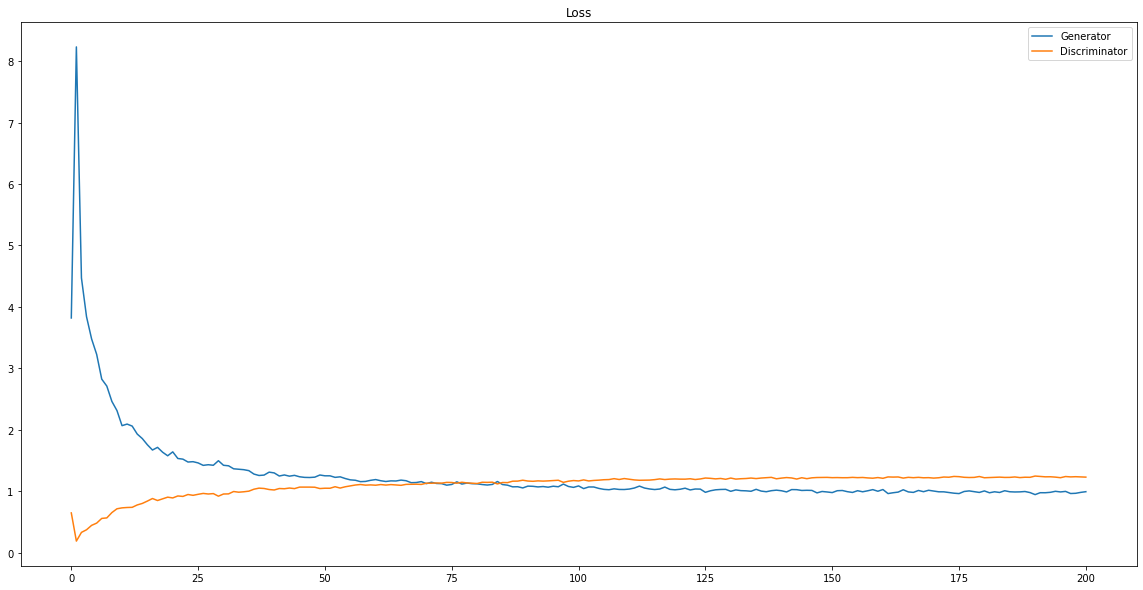

In [12]:
LOSS_SAVE_PATH = '/content/drive/MyDrive/Pytorch Basic/deeplearningbro/pytorch/models/gan_loss.png'

plt.figure(figsize=(20,10))
plt.plot(g_losses)
plt.plot(d_losses)
plt.legend(['Generator','Discriminator'])
plt.title('Loss')
plt.savefig('gan_loss.png')